In [138]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
%matplotlib inline
pd.options.display.max_columns=1000
pd.options.display.max_rows=10

In [2]:
app_train = pd.read_csv('C://Users/matth/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=70000,random_state=42)
app_test = pd.read_csv('C://Users/matth/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True)

In [3]:
app_train["TARGET"].value_counts()

0    64364
1     5636
Name: TARGET, dtype: int64

In [4]:
app_train_0=app_train[app_train['TARGET']==0]
app_train_1=app_train[app_train['TARGET']==1]
app_train_0=app_train_0.sample(n=5000,replace=False,random_state=42)
app_train_1=app_train_1.sample(n=5000,replace=False,random_state=42)
app_train=app_train_1.append(app_train_0,ignore_index=True)
app_train=app_train.sample(frac=1,random_state=42).reset_index(drop=True)

In [5]:
app=app_train.append(app_test,ignore_index=True)
app=app.drop("SK_ID_CURR",axis=1)
len(app[app["TARGET"]==0]),len(app[app["TARGET"]==1])

(5000, 5000)

In [6]:
categorical_features=app.select_dtypes(include="object").columns
unique_values=[len(app[x].unique()) for x in categorical_features]
print(f'Using pd get_dummies for all categorical features will lead to {sum(unique_values)} new features')

Using pd get_dummies for all categorical features will lead to 144 new features


In [7]:
get_dummies=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:]
print(f'Using pd get_dummies for the simplest 8 features will lead to {get_dummies["Number of unique"].sum()} new features')

Using pd get_dummies for the simplest 8 features will lead to 25 new features


In [8]:
pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8]

,Number of unique
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,19
NAME_TYPE_SUITE,8
NAME_INCOME_TYPE,8
WALLSMATERIAL_MODE,8
WEEKDAY_APPR_PROCESS_START,7
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5


In [9]:
label_encoding=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8].index

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in label_encoding:
    le.fit(list(app[c].values))
    app[c]=le.transform(list(app[c].values))

In [11]:
app=pd.get_dummies(app,drop_first=True)

In [12]:
correlations=app.corr()["TARGET"]

In [13]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [14]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [15]:
correlations.loc["OWN_CAR_AGE","TARGET abs"]

0.09519366733629363

In [16]:
relevant_features=correlations.index[1:16]
relevant_features

Index(['EXT_SOURCE_3', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'DAYS_BIRTH',
       'NAME_EDUCATION_TYPE', 'CODE_GENDER_M', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'FLAG_EMP_PHONE', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG',
       'FLOORSMAX_MODE'],
      dtype='object')

In [47]:
missing_data=[app[x].isna().sum()/len(app[x]) for x in relevant_features if app[x].isna().sum()!=0]
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
missing_data=pd.DataFrame(data=missing_data,index=missing_cols,columns=["% of missing data"])
missing_data['Abs correlation']=[correlations.loc[x,"TARGET abs"] for x in missing_data.index]
missing_data=missing_data.sort_values(by="Abs correlation",ascending=False)
missing_data

,% of missing data,Abs correlation


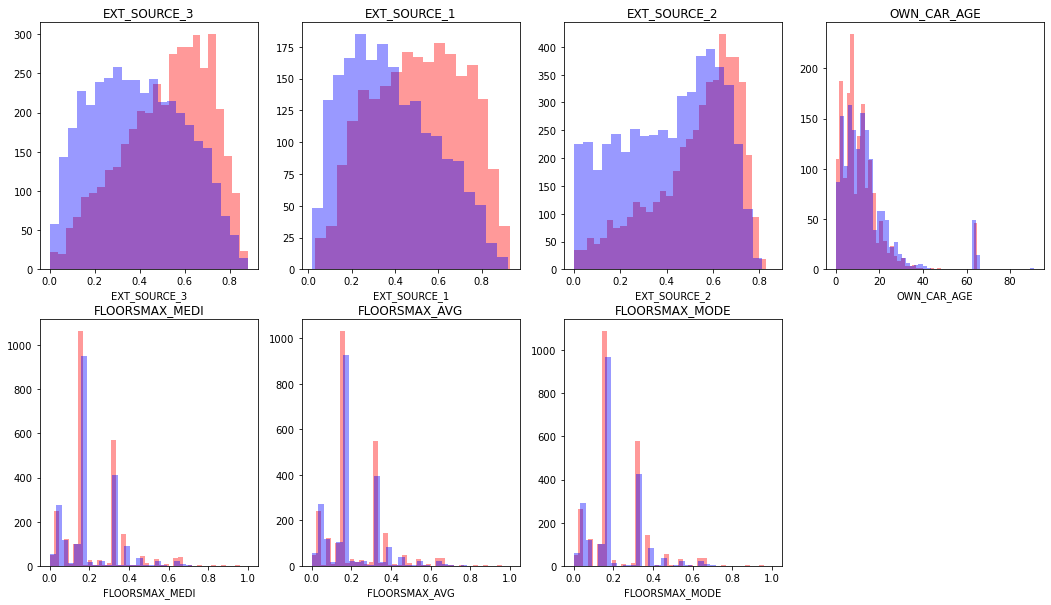

In [18]:
plt.figure(figsize=(18,10))
count=1
for feature in missing_data.index:
    plt.subplot(2,4,count)
    sns.distplot(app[app["TARGET"]==0][feature],color='r',kde=False)
    sns.distplot(app[app["TARGET"]==1][feature],color='b',kde=False)
    #app[x].hist()
    plt.title(feature)
    count+=1

In [19]:
ext1_corr=app.corr()["EXT_SOURCE_1"]

In [20]:
abs(pd.DataFrame(ext1_corr)).sort_values(by="EXT_SOURCE_1", ascending=False)

,EXT_SOURCE_1
EXT_SOURCE_1,1.000000
DAYS_BIRTH,0.537429
TARGET,0.290233
CODE_GENDER_M,0.287010
FLAG_EMP_PHONE,0.253920
...,...
FLAG_DOCUMENT_4,0.001827
FLAG_DOCUMENT_12,0.001480
FLAG_MOBIL,NaN
FLAG_DOCUMENT_2,NaN


In [21]:
missing_ext1_rows= app[app["EXT_SOURCE_1"].isna()].index

In [22]:
#Update the missing variables based on what they're most similar to.
for x in missing_ext1_rows:
    app.loc[x,"EXT_SOURCE_1"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["CODE_GENDER_M"]==app.loc[x,"CODE_GENDER_M"])]\
    ["EXT_SOURCE_1"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [23]:
#In case some of the features are still NA
app["EXT_SOURCE_1"].fillna(app["EXT_SOURCE_1"].median(),inplace=True)

In [24]:
#I repeat the process for EXT 2 and 3 as these are the most important variables.
#I don't want to automate a loop and risk an error (this is good insight as well)
ext2_corr=app.corr()["EXT_SOURCE_2"]

In [25]:
abs(pd.DataFrame(ext2_corr)).sort_values(by="EXT_SOURCE_2", ascending=False)

,EXT_SOURCE_2
EXT_SOURCE_2,1.000000
REGION_RATING_CLIENT,0.318658
REGION_RATING_CLIENT_W_CITY,0.312478
TARGET,0.281873
DAYS_LAST_PHONE_CHANGE,0.222209
...,...
WEEKDAY_APPR_PROCESS_START,0.001287
FLAG_DOCUMENT_20,0.001130
FLAG_MOBIL,NaN
FLAG_DOCUMENT_2,NaN


In [26]:
missing_ext2_rows= app[app["EXT_SOURCE_2"].isna()].index

In [27]:
for x in missing_ext2_rows:
    app.loc[x,"EXT_SOURCE_2"]=app[(app["REGION_RATING_CLIENT"]==app.loc[x,"REGION_RATING_CLIENT"]) & (app["REGION_RATING_CLIENT_W_CITY"]==app.loc[x,"REGION_RATING_CLIENT_W_CITY"])]\
    ["EXT_SOURCE_2"].median()

In [28]:
app["EXT_SOURCE_2"].fillna(app["EXT_SOURCE_2"].median(),inplace=True)

In [29]:
ext3_corr=app.corr()["EXT_SOURCE_3"]

In [30]:
abs(pd.DataFrame(ext3_corr)).sort_values(by="EXT_SOURCE_3", ascending=False)

,EXT_SOURCE_3
EXT_SOURCE_3,1.000000
TARGET,0.295197
DAYS_BIRTH,0.191827
EXT_SOURCE_1,0.136432
DAYS_ID_PUBLISH,0.126416
...,...
FLAG_DOCUMENT_12,0.000405
FLAG_PHONE,0.000112
COMMONAREA_MODE,0.000095
FLAG_DOCUMENT_2,NaN


In [31]:
missing_ext3_rows= app[app["EXT_SOURCE_3"].isna()].index

In [32]:
for x in missing_ext3_rows:
    app.loc[x,"EXT_SOURCE_3"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["DAYS_ID_PUBLISH"]==app.loc[x,"DAYS_ID_PUBLISH"])]\
    ["EXT_SOURCE_3"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [33]:
app["EXT_SOURCE_3"].fillna(app["EXT_SOURCE_3"].median(),inplace=True)

In [35]:
#Make sure to absolute it!
oca_corr=app.corr()["OWN_CAR_AGE"]

In [37]:
abs(pd.DataFrame(oca_corr)).sort_values(by="OWN_CAR_AGE", ascending=False)

,OWN_CAR_AGE
OWN_CAR_AGE,1.000000
AMT_INCOME_TOTAL,0.141132
AMT_GOODS_PRICE,0.101651
REGION_RATING_CLIENT_W_CITY,0.099424
REGION_RATING_CLIENT,0.097657
...,...
AMT_REQ_CREDIT_BUREAU_HOUR,0.000064
FLAG_DOCUMENT_2,NaN
FLAG_DOCUMENT_4,NaN
FLAG_DOCUMENT_10,NaN


In [38]:
missing_oca_rows= app[app["OWN_CAR_AGE"].isna()].index

In [39]:
for x in missing_oca_rows:
    app.loc[x,"OWN_CAR_AGE"]=app[(app["AMT_INCOME_TOTAL"]==app.loc[x,"AMT_INCOME_TOTAL"]) & (app["AMT_GOODS_PRICE"]==app.loc[x,"AMT_GOODS_PRICE"])]\
    ["OWN_CAR_AGE"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [40]:
app["OWN_CAR_AGE"].fillna(app["EXT_SOURCE_3"].median(),inplace=True)

In [44]:
[app[x].isna().sum()/len(app) for x in relevant_features if app[x].isna().sum() !=0]

[0.48631349584638434, 0.48631349584638434, 0.48631349584638434]

In [46]:
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
for x in missing_cols:
    app[x].fillna(app[x].median(),inplace=True)

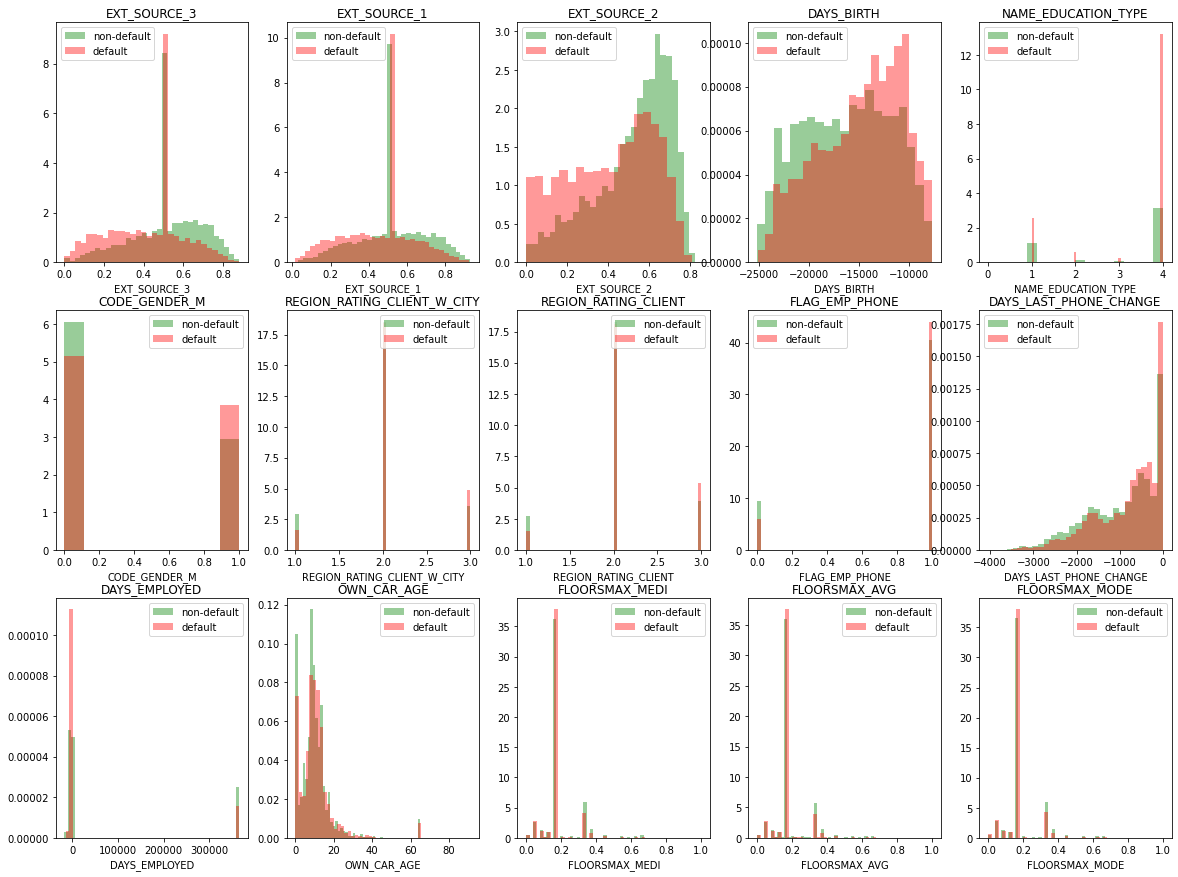

In [48]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    plt.subplot(3,5,counter)
    sns.distplot(app[app["TARGET"]==0][x],color="g",label="non-default",kde=False,norm_hist=True)
    sns.distplot(app[app["TARGET"]==1][x],color="r",label="default",kde=False,norm_hist=True)
    plt.legend()
    plt.title(x)
    counter+=1

In [49]:
#Testing out a new feature by adding the top 3 up
app["EXT_SOURCE_COMBINED"]=app['EXT_SOURCE_1']+app['EXT_SOURCE_2']+app['EXT_SOURCE_3'""]
app.corr()["TARGET"]["EXT_SOURCE_COMBINED"]

-0.3738525170256428

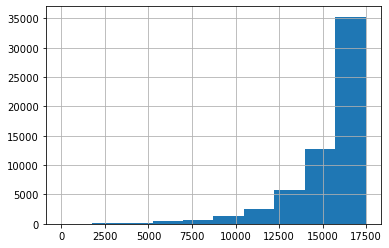

In [50]:
#Assume everyone with outlier days employed is employed long enough
#I also reset this as negative age doesn't make sense
outlier_index=app[app["DAYS_EMPLOYED"]>15000].index
app.loc[outlier_index,"DAYS_EMPLOYED"]=0
app["DAYS_EMPLOYED"]=app["DAYS_EMPLOYED"]-app["DAYS_EMPLOYED"].min()
app["DAYS_EMPLOYED"].hist()

In [51]:
app["DAYS_LAST_PHONE_CHANGE"]=app["DAYS_LAST_PHONE_CHANGE"]-app["DAYS_LAST_PHONE_CHANGE"].min()

In [52]:
correlations=app.corr()["TARGET"]

In [53]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [54]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [56]:
relevant_features=correlations.index[1:16]
relevant_features

Index(['EXT_SOURCE_COMBINED', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'DAYS_BIRTH', 'NAME_EDUCATION_TYPE', 'CODE_GENDER_M',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'FLAG_EMP_PHONE',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'NAME_INCOME_TYPE',
       'FLAG_DOCUMENT_3', 'DAYS_ID_PUBLISH'],
      dtype='object')

In [79]:
#Does it matter if I fit_transform my features before/after splitting into train/test data?
from sklearn.preprocessing import StandardScaler,RobustScaler
ntrain=app["TARGET"].notna().sum()
y=app["TARGET"][:ntrain]
X=app[relevant_features][:ntrain]

X_final=app[relevant_features][ntrain:]
X=StandardScaler().fit_transform(X)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a5031b28c8>,
 Text(0.5, 1.0, 'Kbest scores'))

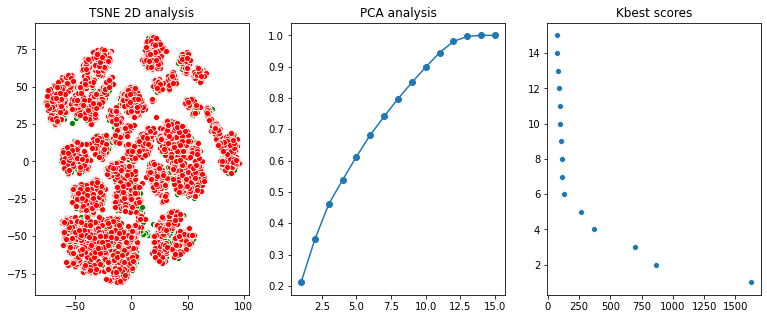

In [80]:
#TSNE shows a pretty poor split (green and red is a mess)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

plt.figure(figsize=(13,5))
mask=y==0

tsne=TSNE(n_components=2)
X_tsne=tsne.fit_transform(X)
plt.subplot(1,3,1)
sns.scatterplot(x=X_tsne[mask,0],y=X_tsne[mask,1],color='g')
sns.scatterplot(x=X_tsne[~mask,0],y=X_tsne[~mask,1],color='r')
plt.title("TSNE 2D analysis")

pca=PCA()
pca.fit(X)
components=range(1,len(pca.explained_variance_ratio_)+1)
plt.subplot(1,3,2)
plt.plot(components,pca.explained_variance_ratio_.cumsum(),marker='o'),plt.title("PCA analysis")
                
kbest=SelectKBest(k="all")
kbest.fit(X,y)
plt.subplot(1,3,3)
sns.scatterplot(kbest.scores_,components),plt.title("Kbest scores")


In [41]:
#Poly transformation not useful
#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(2)
#poly_features=poly.fit_transform(X)
#poly_features.shape,X.shape

([<matplotlib.lines.Line2D at 0x1a511607088>],
 Text(0.5, 1.0, 'KMeans silhuoette vs n.o of clusters'))

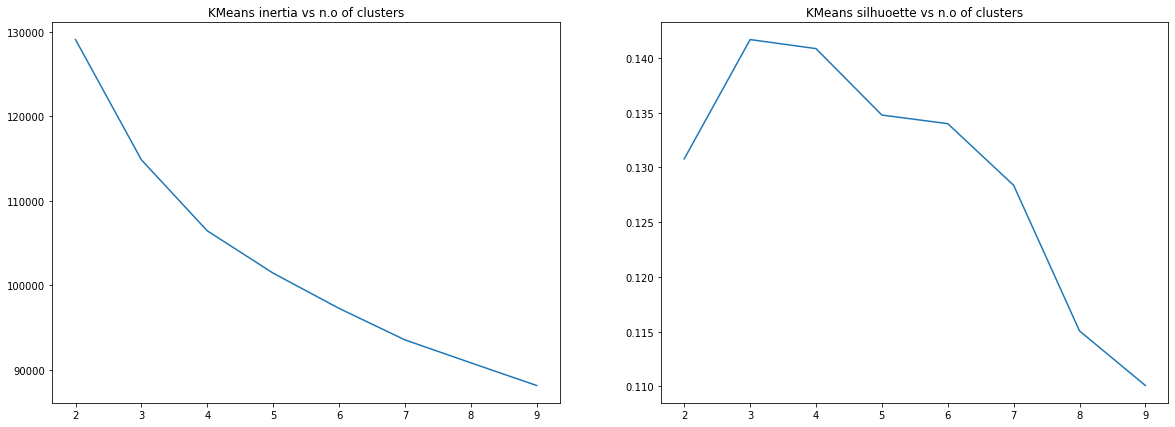

In [166]:
#While not specifically needed (I need to predict defaults), I figure it's worth a shot to see if any new insights can be gained
#This is unsupervised so I don't provide the "TARGET" variable. Results are poor without feature reduction
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#sns.scatterplot(X_train_pca[mask])
kmeans_df=pd.DataFrame(columns=['inertia','silhuoette'],index=range(2,10))

for clusters in kmeans_df.index:
    km = KMeans(n_clusters=clusters, random_state=42)
    km.fit(X)
    kmeans_df.loc[clusters,'inertia']=km.inertia_
    kmeans_df.loc[clusters,'silhuoette']=silhouette_score( X , km.predict(X) )

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(kmeans_df["inertia"]),plt.title("KMeans inertia vs n.o of clusters")
plt.subplot(1,2,2)
plt.plot(kmeans_df["silhuoette"]),plt.title("KMeans silhuoette vs n.o of clusters")

-------------------- PCA:  2 --------------------
-------------------- PCA:  4 --------------------
-------------------- PCA:  6 --------------------
-------------------- PCA:  8 --------------------


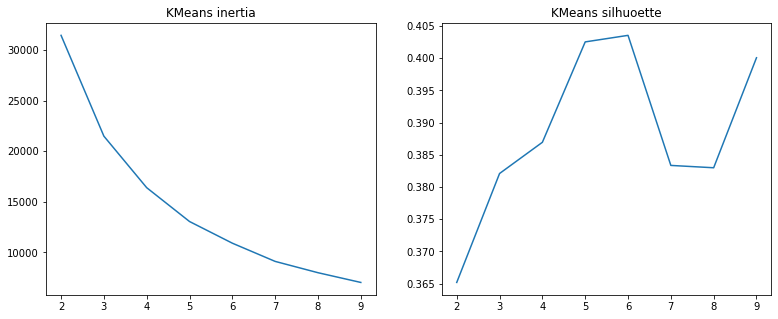

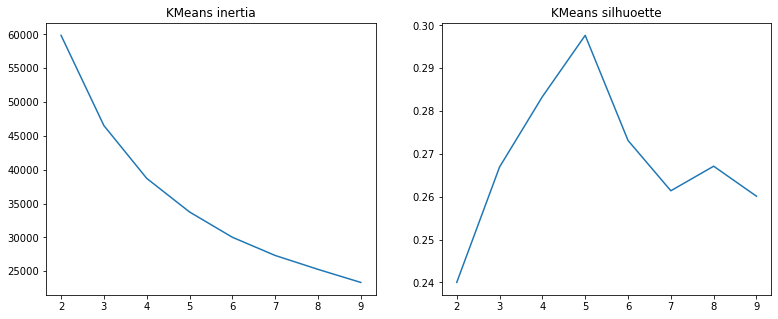

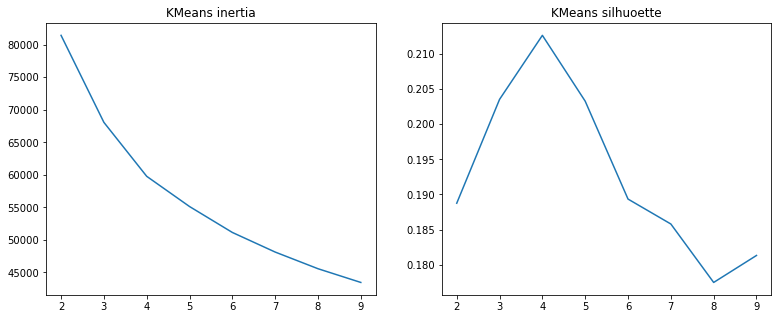

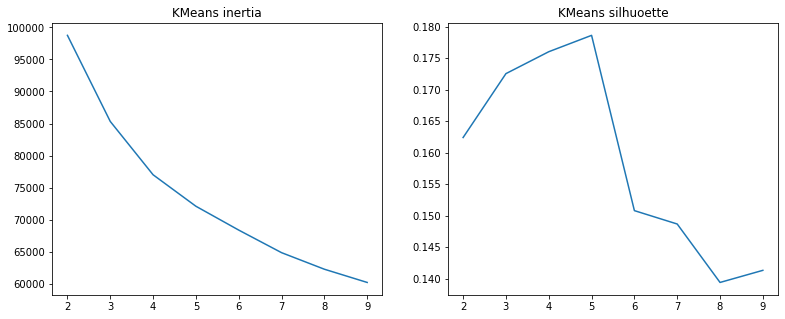

In [160]:
#I run KMeans again but after feature reduction (PCA). Note: this is not completely unsupervised as I already
#handpicked features based on TARGET


for k in range(2,10,2):
    print("-"*20,"PCA: ",k, "-"*20)
    pca=PCA(n_components=k)
    X_unsupervised=pca.fit_transform(X)
    kmeans_df=pd.DataFrame(columns=['inertia','silhuoette'],index=range(2,10))

    for clusters in kmeans_df.index:
        km = KMeans(n_clusters=clusters, random_state=42)
        km.fit(X_unsupervised)
        kmeans_df.loc[clusters,'inertia']=km.inertia_
        kmeans_df.loc[clusters,'silhuoette']=silhouette_score(X_unsupervised, km.predict(X_unsupervised) )

    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plt.plot(kmeans_df["inertia"]),plt.title("KMeans inertia")
    plt.subplot(1,2,2)
    plt.plot(kmeans_df["silhuoette"]),plt.title("KMeans silhuoette")

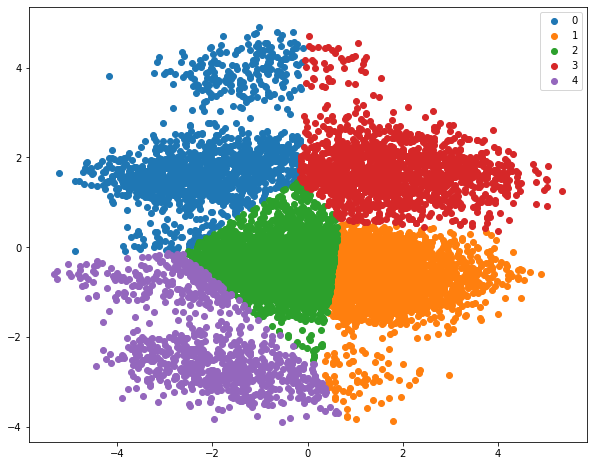

In [168]:
#Based on silhuoette/inertia scores, the best clustering seems to be PCA with 2 components.
#I'll try clustering and see what we get
#Edit: It's just a giant blob. Either this data is unsuited for clustering or it's been reduced too significantly
# as I only took the top 15-16 correlations to TARGET variable
# As the main goal is to predict defaults, I leave clustering aside for now.

pca=PCA(n_components=2)
X_unsupervised=pca.fit_transform(X)
best_km = KMeans(n_clusters=5, random_state=42)
best_km.fit(X_unsupervised)
clusters=best_km.predict(X_unsupervised)

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(5):
    ax.scatter(X_unsupervised[clusters==i, 0], X_unsupervised[clusters==i, 1], label=i)
ax.legend()
plt.show()

In [176]:
from sklearn.model_selection import train_test_split,cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#This is already done prior to feature reduction observation
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

In [170]:
#Turns out T-SNE seems unusable for modelling

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

test_range=range(6,15)
lr=LogisticRegression(max_iter=500)
feature_scoring=pd.DataFrame(columns=["kbest score","pca score"],index=test_range)

for i in test_range:
    kbest=SelectKBest(k=i)
    pca=PCA(n_components=i)
    #tsne=TSNE(n_components=3)
    
    X_train_kbest=kbest.fit_transform(X_train,y_train)
    X_train_pca=pca.fit_transform(X_train)
    #X_train_tsne=tsne.fit_transform(X_train)
    
    X_test_kbest=kbest.transform(X_test)
    X_test_pca=pca.transform(X_test)
    #X_test_tsne=pca.transform(X_test)
    
    
    kbest_train=lr.fit(X_train_kbest,y_train)
    kbest_score=lr.predict_proba(X_test_kbest)[:,1]
    feature_scoring.loc[i,'kbest score']=roc_auc_score(y_test,kbest_score)
    
    pca_train=lr.fit(X_train_pca,y_train)
    pca_score=lr.predict_proba(X_test_pca)[:,1]
    feature_scoring.loc[i,'pca score']=roc_auc_score(y_test,pca_score)
    
    #tsne_train=lr.fit(X_train_tsne,y_train)
    #tsne_score=lr.predict_proba(X_test_tsne)[:,1]
    #feature_scoring.loc[i,'tsne score']=roc_auc_score(y_test,tsne_score)    
    
feature_scoring.sort_values(by="pca score", ascending=False,inplace=True)
feature_scoring

,kbest score,pca score
13,0.736404,0.739907
14,0.739204,0.739632
12,0.736075,0.739528
11,0.73565,0.738532
10,0.735956,0.737841
9,0.731728,0.734424
8,0.73057,0.734371
6,0.728111,0.734306
7,0.729775,0.73426


In [171]:
#I'm going with PCA

best_features=feature_scoring.index[0]
pca=PCA(n_components=best_features)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)
#X_train_pca=kbest.fit_transform(X_train,y_train)
#X_test_pca=kbest.transform(X_test)

In [172]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

lr=LogisticRegression()
svc=SVC(probability=True)
knn=KNeighborsClassifier()
dtr=DecisionTreeClassifier()
rfc=RandomForestClassifier()

models={"Logistic regression":lr,"Support vector classifier": svc,"K neighbours classifier":knn, \
       "Decision tree classifier": dtr, "Random forest classifier": rfc}

In [173]:
#Untuned model predictions and score
base_model_scores=pd.DataFrame(index=models.keys(),columns=[["training score","ROC AUC"]])
t0=time.time()
for key,model in models.items():
    model.fit(X_train_pca,y_train)
    train_score=cross_val_score(model,X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    base_model_scores.loc[key,"training score"]=train_score.mean()
    base_model_scores.loc[key,"ROC AUC"]=roc
    print(time.time()-t0)
base_model_scores

0.05186963081359863
39.85309362411499
40.79280138015747
41.28103232383728
49.538796186447144


,training score,ROC AUC
Logistic regression,0.67425,0.739907
Support vector classifier,0.666125,0.724405
K neighbours classifier,0.61725,0.648289
Decision tree classifier,0.576125,0.576656
Random forest classifier,0.6505,0.717555


In [174]:
#Untuned model average predictions
p1=lr.predict_proba(X_test_pca)[:,1]
p2=svc.predict_proba(X_test_pca)[:,1]
p3=knn.predict_proba(X_test_pca)[:,1]
p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]

p_ave=(p1+p5)/2
roc_auc_score(y_test,p_ave)

0.7363384411965622

In [102]:
#from sklearn.model_selection import learning_curve
#x=1
#plt.figure(figsize=(15,5))
#for key, model in models.items():
#    train_sizes, train_scores, test_scores=learning_curve(model,X_train_pca,y_train)
#    plt.subplot(1,5,x)
#    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
#    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
#    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0,1)),plt.title(key)

#    x=x+1

In [181]:
#I prioritize precision (even though the competition requests for roc_auc) because
#a  false negative is not as costly as a false positive
def objective(model,hyperparameters,iteration):
    scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']
    cv_results=cross_validate(lr,X_train_pca,y_train,scoring=scoring,cv=3)['test_precision_macro'].mean()
    #cv_results=cross_val_score(model,X_train_pca,y_train).mean()
    
    model.fit(X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    
    return (cv_results,roc,hyperparameters)

In [ ]:
#eh I don't even use this at all lol

In [182]:
lr_param_grid={"penalty": ['l1','l2','elasticnet','none'],
           "C": [0.001,0.01,0.1,1,10,100],
           "dual": [True,False],
            "fit_intercept": [True,False],
            "solver": ['lbfgs', 'sag', 'saga'],
            "max_iter": [int(x) for x in np.linspace(start=100,stop=300,num=10)]}

rfc_param_grid={"n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                "criterion": ['gini','entropy'],
                "max_features":["auto", "sqrt", "log2"],
                "bootstrap": [True,False]}

svc_param_grid={"C":[0.01,0.1,1,10,100],
                "kernel":['linear', 'poly', 'rbf', 'sigmoid'],
                "gamma":['scale','auto'],
                "shrinking":[True,False],
                "probability":[True]}


In [183]:
#I use random as the model is too slow otherwise
from sklearn.model_selection import RandomizedSearchCV
lr_random=RandomizedSearchCV(estimator=lr,param_distributions=lr_param_grid,n_iter=10,cv=3,verbose=2)
lr_random.fit(X_train_pca,y_train)
lr_random.best_params_,lr_random.best_score_,lr_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001 
[CV]  solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001 
[CV]  solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001 
[CV]  solver=lbfgs, penalty=none, max_iter=144, fit_intercept=False, dual=True, C=0.001, total=   0.0s
[CV] solver=saga, penalty=l2, max_iter=144, fit_intercept=True, dual=False, C=1 
[CV]  solver=saga, penalty=l2, max_iter=144, fit_intercept=True, dual=False, C=1, total=   0.0s
[CV] solver=saga, penalty=l2, max_iter=144, fit_intercept=True, dual=False, C=1 
[CV]  solver=saga, penalty=l2, max_iter=144, fit_intercept=True, dual=False, C=1, total=   0.0s
[CV] solver=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 446, in _check_solver
    "dual=False, got dual=%s" % (solver, dual))
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 

[CV]  solver=lbfgs, penalty=none, max_iter=233, fit_intercept=False, dual=False, C=0.001, total=   0.0s
[CV] solver=lbfgs, penalty=none, max_iter=233, fit_intercept=False, dual=False, C=0.001 
[CV]  solver=lbfgs, penalty=none, max_iter=233, fit_intercept=False, dual=False, C=0.001, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1 
[CV]  solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1 
[CV]  solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1, total=   0.0s
[CV] solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1 
[CV]  solver=saga, penalty=none, max_iter=188, fit_intercept=False, dual=False, C=1, total=   0.0s
[CV] solver=saga, penalty=elasticnet, max_iter=166, fit_intercept=True, dual=False, C=1 
[CV]  solver=saga, penalty=elasticnet, max_iter=166, fit_intercep

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\linear_model\_logis

({'solver': 'saga',
  'penalty': 'l1',
  'max_iter': 255,
  'fit_intercept': True,
  'dual': False,
  'C': 10},
 0.6731245053483094,
 LogisticRegression(C=10, max_iter=255, penalty='l1', solver='saga'))

In [184]:
#This takes quite a long time
svc_random=RandomizedSearchCV(estimator=svc,param_distributions=svc_param_grid,n_iter=10,cv=3,verbose=2)
svc_random.fit(X_train_pca,y_train)
svc_random.best_params_,svc_random.best_score_,svc_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.1s
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.0s
[CV] shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01 
[CV]  shrinking=False, probability=True, kernel=linear, gamma=auto, C=0.01, total=   2.0s
[CV] shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1 
[CV]  shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1, total=   3.9s
[CV] shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1 
[CV]  shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1, total=   3.8s
[CV] shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1 
[CV]  shrinking=False, probability=True, kernel=rbf, gamma=scale, C=0.1, total=   3.8s
[CV] shrinking=False, probability=True, kernel=poly, gamma=scale, C=0.01 
[CV]  shrinking=False, probability=True, kernel=poly, gamma=scale, C=0.01, total=   2.9s
[CV] shrinking=False, probability=True, kernel=poly, gamma=scale, C=0.01 
[CV]  shrinking=False, probabil

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 38.5min finished


({'shrinking': True,
  'probability': True,
  'kernel': 'linear',
  'gamma': 'auto',
  'C': 100},
 0.671874614697919,
 SVC(C=100, gamma='auto', kernel='linear', probability=True))

In [185]:
rf_random=RandomizedSearchCV(estimator=rfc,param_distributions=rfc_param_grid,n_iter=10,cv=3,verbose=2)
rf_random.fit(X_train_pca,y_train)
rf_random.best_params_,rf_random.best_score_,rf_random.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True, total=  26.1s
[CV] n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s


[CV]  n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True, total=  26.5s
[CV] n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1400, max_features=sqrt, criterion=entropy, bootstrap=True, total=  25.9s
[CV] n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True 
[CV]  n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True, total=   3.6s
[CV] n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True 
[CV]  n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True, total=   3.8s
[CV] n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True 
[CV]  n_estimators=200, max_features=auto, criterion=entropy, bootstrap=True, total=   3.7s
[CV] n_estimators=1800, max_features=log2, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1800, max_features=log2, criterion=entropy, bootstrap=True, total=  33.9s
[CV] n_estimators=1800, max_features=log2, criterion=entro

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.6min finished


({'n_estimators': 1400,
  'max_features': 'sqrt',
  'criterion': 'entropy',
  'bootstrap': True},
 0.6596249737349974,
 RandomForestClassifier(criterion='entropy', max_features='sqrt',
                        n_estimators=1400))

In [108]:
#Tuned model average predictions
rfc=rf_random.best_estimator_
rfc.fit(X_train_pca,y_train)
lr=lr_random.best_estimator_
lr.fit(X_train_pca,y_train)
svc=svc_random.best_estimator_
svc.fit(X_train_pca,y_train)

p1=lr.predict_proba(X_test_pca)[:,1]
p2=svc.predict_proba(X_test_pca)[:,1]
#p3=knn.predict_proba(X_test_pca)[:,1]
#p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]


In [109]:
roc_auc_score(y_test,p1),roc_auc_score(y_test,p2),roc_auc_score(y_test,p5)

(0.7390619014613471, 0.7386738358782634, 0.724689472520856)

In [110]:
p_ave=(p1+p2+p5)/3
roc_auc_score(y_test,p_ave)

0.7406681729212237

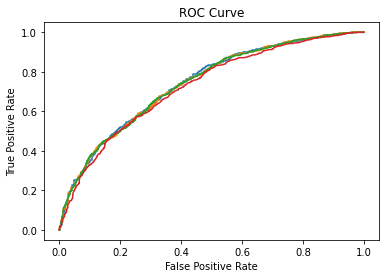

In [168]:
from sklearn.metrics import roc_curve
f, ax = plt.subplots()
for x in [p_ave,p1,p2,p5]:
    
    tpr,fpr,thresholds=roc_curve(y_test,x)
    plt.plot(1-fpr,1-tpr)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.show()

In [169]:
classification_report(y_test,p_ave)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [111]:
X_final_pca=pca.transform(scaler.transform(X_final))

In [112]:
y_final=(lr.predict_proba(X_final_pca)[:,1]+rfc.predict_proba(X_final_pca)[:,1]+svc.predict_proba(X_final_pca)[:,1])/3
final_guess=pd.DataFrame(y_final)

In [113]:
submission=pd.DataFrame(app_test["SK_ID_CURR"])

In [114]:
submission["TARGET"]=final_guess

In [115]:
submission.to_csv("submission.csv",index=False,header=True)

In [116]:
#Old material

import itertools

def grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
        i+=1
        if i>5:
            break
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [117]:
#Seems like adjusting logistic regression hyperparameters has minimal impact on the results
grid_results=grid_search(lr,lr_param_grid)
grid_results

0.18909597396850586
0.46193575859069824
0.7232825756072998
0.9948084354400635
1.2650859355926514
1.5608038902282715


,training score,test ROC AUC,Hyperparameters
0,0.67125,0.739068,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
1,0.67125,0.739067,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
2,0.67125,0.739065,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
3,0.67125,0.739064,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
4,0.67125,0.739062,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."
5,0.67125,0.739062,"{'penalty': 'l1', 'C': 0.001, 'dual': True, 'f..."


In [118]:
grid_search(rfc,rfc_param_grid)

KeyboardInterrupt: 

In [ ]:
import random
def random_grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    
    for i in range(10):
        hyperparameters={k:random.sample(v,1)[0] for k,v in param_grid.items()}
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [ ]:
random_grid_search(rfc,rfc_param_grid)